# **TimeGAN**

Unofficial implementation in PyTorch.

Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

### **Import of Packages**

In [ ]:
import os
import time

import numpy as np
import pandas as pd

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt

from discriminative_metrics import discriminative_score_metrics
from predictive_metrics import predictive_score_metrics

### **Random Seeds**

In [2]:
#Random seeds
np.random.seed(42)

### **Functions**

In [3]:
def load_dataset(*files: str) -> np.array:
    """Load benchmark data set from csv file."""
    return_list = []
    for file in files:
        path = f'{file}' if file.endswith('csv') else f'{file}.csv'
        if path.endswith('stock_data.csv'):
            #Flip data for chronological order
            data = np.asarray(pd.read_csv(path))[::-1]
        elif path.endswith('energy_data.csv'):
            data = np.asarray(pd.read_csv(path))
        else:
            #Sine signal
            # dim (10000, 5)
            temp = []
            for k in range(3):
                #Randomly drawn frequency and phase
                freq = np.random.uniform(0, 0.1)
                phase = np.random.uniform(0, 0.1)

                temp.append([np.sin(freq*j + phase) for j in range(1000)])

            data = np.stack(np.transpose(np.asarray(temp)))

        return_list.extend([data])

    return return_list if len(return_list) > 1 else return_list.pop()

In [4]:
def preprocessing(*inputs: tuple(), sequence_length: int(), shuffle_stack: bool() = True, random_state: int() = None) -> np.ndarray:
    """Conduct preprocessing: scale data, slice data into sequences and shuffle data stack.
    Consistent shuffling between multiple data stacks must be performed separetaly."""
    return_list = []
    for data, bool_scale in inputs:
        #Create Minimum-Maximum scaler
        if bool_scale:
            scaler = MinMaxScaler().fit(data)
            data = scaler.transform(data)
            print('\nMaximum values:\n', scaler.data_max_, '\nMinimum values:\n', scaler.data_min_)

        #Create a list holding the sequences defined by sliding window of width = horizon and stack to a 3-dimensional array (batch, horizon, feature)
        data_stack = np.stack([data[i:i+sequence_length] for i in range(len(data) - sequence_length)])

        if shuffle_stack:
            #In TimeGAN code the dataset is mixed to make it similar to independent and identically distributed (iid)
            data_stack = shuffle(data_stack, random_state=random_state)

        return_list.extend([data_stack, scaler.data_max_, scaler.data_min_]) if bool_scale else return_list.extend([data_stack])

    return return_list if len(return_list) > 1 else return_list.pop()

In [5]:
def low_dimensional_representation(data_ori: np.ndarray, data_gen: np.ndarray, technique: str()) -> np.ndarray:
    """Transform data into low-dimensional representation."""
    assert technique in ['pca', 'tsne']

    sample_no = min([1000, len(data_ori)])
    idx = np.random.permutation(len(data_ori))[:sample_no]
    data_ori, data_gen = np.asarray(data_ori)[idx], np.asarray(data_gen)[idx]
    no, seq_len, dim = data_ori.shape

    prep_data = np.array([np.reshape(np.mean(data_ori[i,:,:], 1), [1,seq_len]).flatten().tolist() for i in range(sample_no)])
    prep_data_hat = np.array([np.reshape(np.mean(data_gen[i,:,:], 1), [1,seq_len]).flatten().tolist() for i in range(sample_no)])

    if technique == 'pca':
        # PCA Analysis
        pca = PCA(n_components = 2)
        pca.fit(prep_data)

        return pca.transform(prep_data), pca.transform(prep_data_hat)

    elif technique == 'tsne':
        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)

        # TSNE anlaysis
        tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, max_iter = 300)
        tsne_result = tsne.fit_transform(prep_data_final)

        return tsne_result[:sample_no], tsne_result[sample_no:]

In [6]:
def plot_distribution_estimate(lowdim_data_ori: np.ndarray, lowdim_data_gen: np.ndarray, technique: str()) -> None:
    """Visualize distribution estimate via sampled data points."""
    fig, ax = plt.subplots()
    #Use rasterized Line2D Artist here instead of scatter. Espacially benefitial when exporting the plot as pdf file (or other vector graphics).
    ax.add_line(mpl.lines.Line2D(lowdim_data_ori[:,0], lowdim_data_ori[:,1], ls='', marker='o', markersize=3, c = 'red', alpha = 0.2, rasterized=True, label='Original'))
    ax.add_line(mpl.lines.Line2D(lowdim_data_gen[:,0], lowdim_data_gen[:,1], ls='', marker='o', markersize=3, c = 'blue', alpha = 0.2, rasterized=True, label='Generated'))
    ax.autoscale_view()
    ax.set_xlabel(f'x-{technique}')
    ax.set_ylabel(f'y-{technique}')
    ax.legend()
    fig.show()

### **Load and prepare Data**

In [7]:
#Data set
data = load_dataset(os.path.join('stock_data'))

#Squence length
seq_len = 24

#Preprocess data
data_train, max_val, min_val = preprocessing((data, True), sequence_length=seq_len)


Maximum values:
 [1.27100000e+03 1.27389001e+03 1.24902002e+03 1.26832996e+03
 1.26832996e+03 8.27681000e+07] 
Minimum values:
 [  49.274517   50.541279   47.669952   49.681866   49.681866 7900.      ]


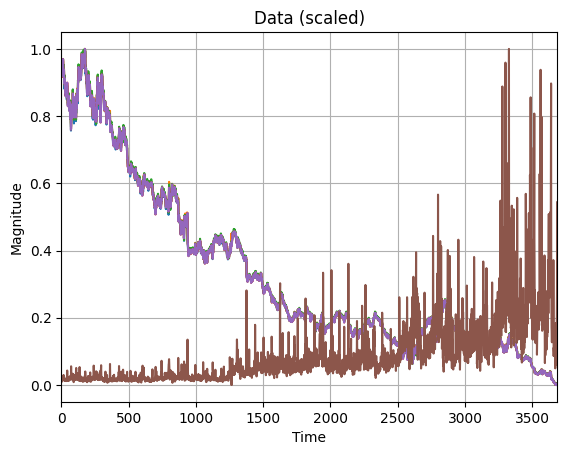

In [8]:
#Visualize the scaled training data
fig, ax = plt.subplots()
ax.plot((data - min_val)/(max_val - min_val))
ax.set_xlim(0, len(data))
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title('Data (scaled)')
ax.grid(True)
fig.show()

### **TimeGAN Networks**

In [9]:
class Embedder(keras.Sequential):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers, name: str = 'Embedder'):
        super().__init__(name=name)
        assert module_name in ['gru', 'lstm']
        #Flexible parameter
        self.sequence_length = None

        self.add(keras.Input(shape=(self.sequence_length, input_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise Exception()
        self.add(keras.layers.Dense(units=hidden_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.sequence_length = sequence_length

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

In [10]:
class Recovery(keras.Sequential):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers, name: str = 'Recovery'):
        super().__init__(name=name)
        assert module_name in ['gru', 'lstm']
        #Flexible parameter
        self.sequence_length = None

        self.add(keras.Input(shape=(self.sequence_length, hidden_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise Exception()
        self.add(keras.layers.Dense(units=input_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.sequence_length = sequence_length

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

In [11]:
class Generator(keras.Sequential):
    def __init__(self, module_name, input_dim, hidden_dim, num_layers, name: str = 'Generator'):
        super().__init__(name=name)
        assert module_name in ['gru', 'lstm']
        #Flexible parameter
        self.sequence_length = None

        self.add(keras.Input(shape=(self.sequence_length, input_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise Exception()
        self.add(keras.layers.Dense(units=hidden_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.sequence_length = sequence_length

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

In [12]:
class Supervisor(keras.Sequential):
    def __init__(self, module_name, hidden_dim, num_layers, name: str = 'Supervisor'):
        super().__init__(name=name)
        assert module_name in ['gru', 'lstm']
        #Flexible parameter
        self.sequence_length = None

        self.add(keras.Input(shape=(self.sequence_length, hidden_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.GRU(units=hidden_dim, return_sequences=True))
            elif module_name == 'lstm':
                self.add(keras.layers.LSTM(units=hidden_dim, return_sequences=True))
            else:
                raise Exception()
        self.add(keras.layers.Dense(units=hidden_dim, activation='sigmoid'))

    def build(self, sequence_length: int):
        self.sequence_length = sequence_length

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

In [13]:
class Discriminator(keras.Sequential):
    def __init__(self, module_name, hidden_dim, num_layers, name: str = 'Discriminator'):
        super().__init__(name=name)
        assert module_name in ['gru', 'lstm']
        #Flexible parameter
        self.sequence_length = None

        self.add(keras.Input(shape=(self.sequence_length, hidden_dim)))
        for _ in range(num_layers):
            if module_name == 'gru':
                self.add(keras.layers.Bidirectional(keras.layers.GRU(units=hidden_dim, return_sequences=True)))
            elif module_name == 'lstm':
                self.add(keras.layers.Bidirectional(keras.layers.LSTM(units=hidden_dim, return_sequences=True)))
            else:
                raise Exception()
        self.add(keras.layers.Dense(units=1, activation=None))

    def build(self, sequence_length: int):
        self.sequence_length = sequence_length

    def call(self, x, training: bool = True):
        return super().call(x, training=training)

### **Loss Functions**

In [14]:
@tf.function
def embedding_loss(x, x_tilde):
    """Compute reconstruction loss between original and recovered sequences."""
    return 10*tf.math.sqrt(keras.losses.MeanSquaredError()(x, x_tilde))

In [15]:
@tf.function
def supervised_loss(h, h_hat_supervise):
    """Compute supervised loss by comparing one-step ahead original latent vectors with supervised original vectors."""
    return keras.losses.MeanSquaredError()(h[:,1:,:], h_hat_supervise[:,:-1,:])

In [16]:
@tf.function
def generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat):
    """Compute combined generator loss from multiple loss measures."""
    gamma = 1

    fake = tf.ones_like(y_fake, dtype=tf.float32)

    #1. Unsupervised generator loss
    g_loss_u = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake)
    g_loss_u_e = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake_e)

    #2. Supervised loss
    g_loss_s = keras.losses.MeanSquaredError()(h[:,1:,:], h_hat_supervise[:,:-1,:])

    #3. Two moments
    g_loss_v1 = tf.math.reduce_mean(tf.math.abs(tf.math.sqrt(tf.math.reduce_std(x_hat, axis=0)) - tf.math.sqrt(tf.math.reduce_std(x, axis=0))))
    g_loss_v2 = tf.math.reduce_mean(tf.math.abs(tf.math.reduce_mean(x_hat, axis=0) - tf.math.reduce_mean(x, axis=0)))
    g_loss_v = g_loss_v1 + g_loss_v2

    return g_loss_u + gamma*g_loss_u_e + 100*tf.math.sqrt(g_loss_s) + 100*g_loss_v

In [17]:
@tf.function
def discriminator_loss(y_real, y_fake, y_fake_e):
    """Compute unsupervised discriminator loss."""
    gamma = 1

    fake = tf.zeros_like(y_fake, dtype=tf.float32)
    valid = tf.ones_like(y_real, dtype=tf.float32)

    #Unsupervised loss
    d_loss_real = keras.losses.BinaryCrossentropy(from_logits=True)(valid, y_real)
    d_loss_fake = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake)
    d_loss_fake_e = keras.losses.BinaryCrossentropy(from_logits=True)(fake, y_fake_e)

    return d_loss_real + d_loss_fake + d_loss_fake_e*gamma

### **TimeGAN**

In [18]:
class TimeGAN():
    def __init__(self, module_name: str = 'gru',
                 input_dim: int = 1,
                 hidden_dim: int = 24,
                 num_layers: int = 3,
                 epochs: int = 1000,
                 batch_size: int = 128,
                 learning_rate: float = 1e-3):

        #Parameters
        self.module_name = module_name
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

        #Networks
        self.embedder = Embedder(module_name, input_dim, hidden_dim, num_layers)
        self.recovery = Recovery(module_name, input_dim, hidden_dim, num_layers)
        self.generator = Generator(module_name, input_dim, hidden_dim, num_layers)
        self.supervisor = Supervisor(module_name, hidden_dim, num_layers-1)
        self.discriminator = Discriminator(module_name, hidden_dim, num_layers)

        #Loss functions
        self.embedding_loss = embedding_loss
        self.supervised_loss = supervised_loss
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss

        #Optimizers
        self.optimizer_e_0 = keras.optimizers.Adam(learning_rate)
        self.optimizer_e = keras.optimizers.Adam(learning_rate)
        self.optimizer_s = keras.optimizers.Adam(learning_rate)
        self.optimizer_g = keras.optimizers.Adam(learning_rate)
        self.optimizer_d = keras.optimizers.Adam(learning_rate)

        #Auxiliary
        self.fitting_time = None
        self.losses = []

    def fit(self, data_training: np.ndarray):
        """TimeGAN training."""
        #Track training time
        self.fitting_time = time.time()

        #Build networks
        self.embedder.build(data_training.shape[1])
        self.recovery.build(data_training.shape[1])
        self.generator.build(data_training.shape[1])
        self.supervisor.build(data_training.shape[1])
        self.discriminator.build(data_training.shape[1])

        #Cast datatype
        data_training = np.float32(data_training)

        #Create TensorFlow data set from training data sequences
        ds_train = tf.data.Dataset.from_tensor_slices(data_training).cache().shuffle(data_training.shape[0])

        #Define 1st training phase, Embedder-Recovery training
        @tf.function
        def train_step_e0(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                x_tilde = self.recovery(h)

                loss_e = self.embedding_loss(x, x_tilde)

            grad_e = tape.gradient(loss_e, self.embedder.trainable_variables + \
                                   self.recovery.trainable_variables)
            self.optimizer_e_0.apply_gradients(zip(grad_e, self.embedder.trainable_variables + \
                                                   self.recovery.trainable_variables))

            return loss_e

        print('Start Embedder-Recovery Training')
        for epoch in range(self.epochs):
            loss_e_record = []
            #Mini-batch training
            for x in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                loss_e = train_step_e0(x)
                loss_e_record.append(loss_e)

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_e:', f'{np.mean(loss_e_record):12.9f}')

        print('Finished Embedder-Rcovery Training\n')

        #Define 2nd training phase, Supervised Loss Only
        @tf.function
        def train_step_s(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)

                loss_s = self.supervised_loss(h, h_hat_supervise)

            grad_s = tape.gradient(loss_s, self.generator.trainable_variables + \
                                   self.supervisor.trainable_variables)
            self.optimizer_s.apply_gradients(zip(grad_s, self.generator.trainable_variables + \
                                                 self.supervisor.trainable_variables))

            return loss_s

        #Reuse recent data set and shuffle
        ds_train = ds_train.shuffle(buffer_size=data_training.shape[0])

        print('Start Training on Supervised Loss only')
        for epoch in range(self.epochs):
            loss_s_record = []
            #Mini-batch training
            for x in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                loss_s = train_step_s(x)
                loss_s_record.append(loss_s)

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_s:', f'{np.mean(loss_s_record):12.9f}')

        print('Finished Training on Supervised Loss only\n')

        #Define 3rd training phase, Joint Training
        #Generator, Supervisor
        @tf.function
        def train_step_g(x, z):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(e_hat)
                h_hat_supervise = self.supervisor(h)
                x_hat = self.recovery(h_hat)
                y_fake = self.discriminator(h_hat)
                y_fake_e = self.discriminator(e_hat)

                loss_g = self.generator_loss(y_fake, y_fake_e, h, h_hat_supervise, x, x_hat)

            grad_g = tape.gradient(loss_g, self.generator.trainable_variables + \
                                   self.supervisor.trainable_variables)

            self.optimizer_g.apply_gradients(zip(grad_g, self.generator.trainable_variables + \
                                                 self.supervisor.trainable_variables))

            return loss_g

        #Embedder, Recovery
        @tf.function
        def train_step_e(x):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                h_hat_supervise = self.supervisor(h)
                x_tilde = self.recovery(h)

                loss_e = self.embedding_loss(x, x_tilde) + 0.1*self.supervised_loss(h, h_hat_supervise)

            grad_e = tape.gradient(loss_e, self.embedder.trainable_variables + \
                                   self.recovery.trainable_variables)

            self.optimizer_e.apply_gradients(zip(grad_e, self.embedder.trainable_variables + \
                                                 self.recovery.trainable_variables))

            return loss_e

        #Discriminator
        @tf.function
        def train_step_d(x, z):
            with tf.GradientTape() as tape:
                h = self.embedder(x)
                e_hat = self.generator(z)
                h_hat = self.supervisor(h)

                y_fake = self.discriminator(h_hat)
                y_real = self.discriminator(h)
                y_fake_e = self.discriminator(e_hat)

                loss_d = self.discriminator_loss(y_real, y_fake, y_fake_e)

            #Check loss thresold and optimize
            if loss_d > 0.15:
                grad_d = tape.gradient(loss_d,
                                       self.discriminator.trainable_variables)
                self.optimizer_d.apply_gradients(zip(grad_d,
                                                     self.discriminator.trainable_variables))

            return loss_d

        print('Start Joint Training')
        for epoch in range(self.epochs):
            loss_g_record = []
            loss_e_record = []
            #Optimize networks concerning generation process twice in one epoch
            for _ in range(2):
                #Extend data set by noise vectors sampled from uniform distribution
                ds_train = tf.data.Dataset.from_tensor_slices((data_training,
                                                               keras.random.uniform(data_training.shape))).cache().shuffle(data_training.shape[0])

                #Mini-batch training
                for x, z in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                    loss_g = train_step_g(x, z)
                    loss_g_record.append(loss_g)

                    loss_e = train_step_e(x)
                    loss_e_record.append(loss_e)

            #Extend data set by noise vectors sampled from uniform distribution
            ds_train = tf.data.Dataset.from_tensor_slices((data_training,
                                                           keras.random.uniform(data_training.shape))).cache().shuffle(data_training.shape[0])

            loss_d_record = []
            #Mini-batch training
            for x, z in ds_train.batch(self.batch_size).prefetch(tf.data.AUTOTUNE):
                loss_d = train_step_d(x, z)
                loss_d_record.append(loss_d)

            self.losses.append([np.mean(loss_g_record), np.mean(loss_e_record), np.mean(loss_d_record)])

            if (epoch + 1) % (0.1*self.epochs) == 0:
                print('Epoch:', repr(epoch + 1).rjust(len(str(self.epochs))), 'of', self.epochs,
                      '| loss_g:', f'{np.mean(loss_g_record):12.9f}',
                      '| loss_e:', f'{np.mean(loss_e_record):12.9f}',
                      '| loss_d:', f'{np.mean(loss_d_record):12.9f}')

        print('Finished Joint Training')

        self.fitting_time = np.round(time.time() - self.fitting_time, 3)
        print('\nElapsed Training Time:', time.strftime('%Hh %Mmin %Ss', time.gmtime(self.fitting_time)), '\n')

    def transform(self, shape: tuple, training: bool = False):
        """TimeGAN sequences generation"""
        @tf.function
        def generate_step(z):
            e_hat = self.generator(z, training=training)
            h_hat = self.supervisor(e_hat, training=training)
            x_hat = self.recovery(h_hat, training=training)

            return x_hat

        #Data set holding noise vectors
        ds_noise = tf.data.Dataset.from_tensor_slices(keras.random.uniform(shape)).shuffle(shape[0])

        sequences_generated = []
        for z in ds_noise.batch(1).prefetch(tf.data.AUTOTUNE):
            x_hat = generate_step(z)

            sequences_generated.append(np.squeeze(x_hat.numpy()))

        return np.stack(sequences_generated)

### **GPU Accelerator**

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
tf.config.set_soft_device_placement(True)

### **TimeGAN Training**

In [21]:
model = TimeGAN(input_dim=data_train.shape[-1], hidden_dim=12, epochs=1000)

In [22]:
model.fit(data_train)

Start Embedder-Recovery Training
Epoch:  100 of 1000 | loss_e:  0.143685237
Epoch:  200 of 1000 | loss_e:  0.099242792
Epoch:  300 of 1000 | loss_e:  0.044049662
Epoch:  400 of 1000 | loss_e:  0.035096321
Epoch:  500 of 1000 | loss_e:  0.032959472
Epoch:  600 of 1000 | loss_e:  0.040605091
Epoch:  700 of 1000 | loss_e:  0.028917145
Epoch:  800 of 1000 | loss_e:  0.027407201
Epoch:  900 of 1000 | loss_e:  0.025956038
Epoch: 1000 of 1000 | loss_e:  0.026264366
Finished Embedder-Rcovery Training

Start Training on Supervised Loss only
Epoch:  100 of 1000 | loss_s:  0.000406262
Epoch:  200 of 1000 | loss_s:  0.000354708
Epoch:  300 of 1000 | loss_s:  0.000342775
Epoch:  400 of 1000 | loss_s:  0.000338091
Epoch:  500 of 1000 | loss_s:  0.000336329
Epoch:  600 of 1000 | loss_s:  0.000333765
Epoch:  700 of 1000 | loss_s:  0.000332772
Epoch:  800 of 1000 | loss_s:  0.000329880
Epoch:  900 of 1000 | loss_s:  0.000329470
Epoch: 1000 of 1000 | loss_s:  0.000327373
Finished Training on Supervised 

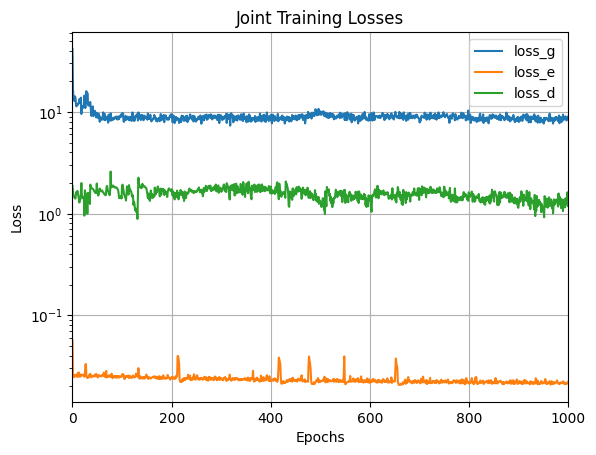

In [29]:
#Visualize joint training losses
if model.losses:
    losses = np.array(model.losses)

    fig, ax = plt.subplots()
    ax.semilogy(losses)
    ax.legend(['loss_g', 'loss_e', 'loss_d'])
    ax.set_xlim(0, len(losses))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Joint Training Losses')
    ax.grid(True)
    fig.show()

### **Evaluation**

In [23]:
#Synthesize sequences
data_gen = model.transform(data_train.shape)

In [26]:
predictive_score_metrics(data_train, data_gen)

100%|██████████| 5000/5000 [10:45<00:00,  7.74it/s]


2.4441978731769077e-05

In [27]:
discriminative_score_metrics(data_train, data_gen)

100%|██████████| 2000/2000 [04:28<00:00,  7.45it/s]


0.0

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.029544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.818760
[t-SNE] KL divergence after 300 iterations: 0.933969


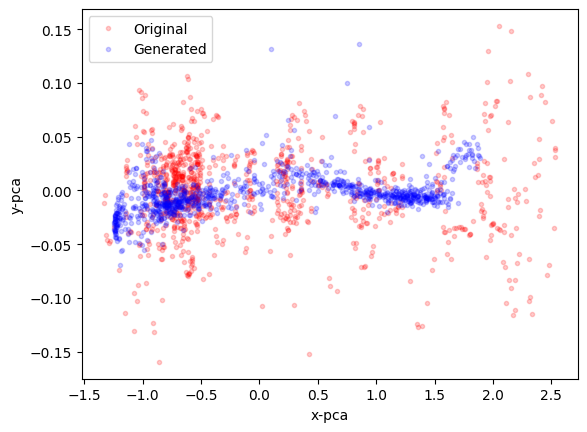

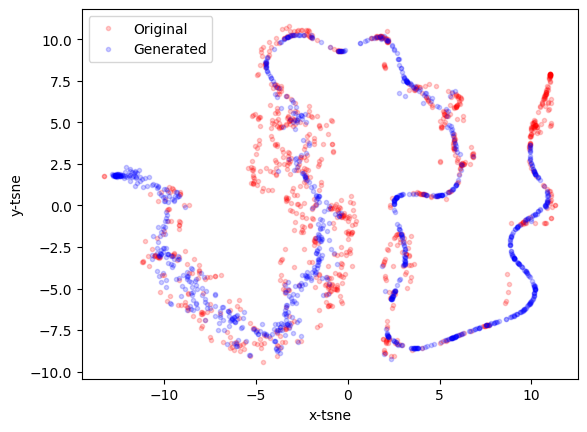

In [30]:
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'pca'), 'pca')
plot_distribution_estimate(*low_dimensional_representation(data_train, data_gen, 'tsne'), 'tsne')